This notebook attempts to perform basic EDA and evaluate linear classification models Gaussian Naive Bayes and Logistic Regression on to Kaggle dataset https://www.kaggle.com/c/titanic

Steps:

1. Load the required Libraries
2. Loading the test and train datasets
3. Examine the data, data types, and missing values
Explore all the missing values and verify to see if this data can be used to fill any missing values or create new features. 
Two features which were further explored 
a) Cabin : This has large number of missing values, but we could create a new feature, Deck based on the information available. Though the test data set suggets people with a deck have better survival rate, it did not prove to be much of value and was overfitting the data. Hence this coulumn is dropped. 
b) Name : This seems the most interesting feature as it had a lot of information embedded with in to create new features
  -- Title : Title is extracted from the name and the missing values for Age are embedded by group Pclass, Sex and Title 
 -- We could also extract last name and group the families together, but this was not handled.
c) Missing values for Embarked and Fare are handled by grouping using mode.
 
4. Add New Features : 
a) HasFamily : Identity if the person is travelling alone or with family 
b) Convert Age and Fare to Bins and then convert them to binary  variables using pd_dummies
c) Convert categorical variables to either Ordinal or binary using one-hot encoding 

  df_final has the final list of features which yielded better results for     model.

5. Two models, Logistic Regression and Naive Bayes are compared with help of ROC and P/R curves and Logistic Regression seems to the best fit based on area of ROC curve and the same can be confirmed based on Kaggle scores



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")
sample,features = df_train.shape[0],df_train.shape[1]
print(f"Train data contains {sample} rows and {features} columns")
sample,features = df_test.shape[0],df_test.shape[1]
print(f"Test data containts {sample} rows and {features} columns")

Train data contains 891 rows and 12 columns
Test data containts 418 rows and 11 columns


In [3]:
df = df_train.append(df_test, ignore_index=True)
# create indexes to separate data later on
train_idx = len(df_train)
test_idx = len(df) - len(df_test)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [5]:
"Check the Co-relation Plot"
corr = df_train[df_train.columns[1:]].corr()['Survived'][:]
corr
#Not much information can be deduced except for PClass

Survived    1.000000
Pclass     -0.338481
Age        -0.077221
SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Name: Survived, dtype: float64

In [6]:
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
396,397,0.0,3,"Olsson, Miss. Elina",female,31.0,0,0,350407,7.8542,NaN,S
838,839,1.0,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S
484,485,1.0,1,"Bishop, Mr. Dickinson H",male,25.0,1,0,11967,91.0792,B49,C
639,640,0.0,3,"Thorneycroft, Mr. Percival",male,NaN,1,0,376564,16.1000,NaN,S
197,198,0.0,3,"Olsen, Mr. Karl Siegwart Andreas",male,42.0,0,1,4579,8.4042,NaN,S


Survived    31.932773
Age         20.091673
Fare         0.076394
Cabin       77.463713
Embarked     0.152788
dtype: float64

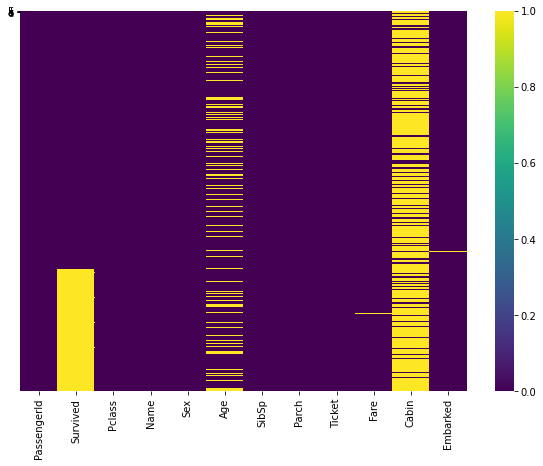

In [7]:
#Check for missing values
plt.figure(figsize=(10,7))
sns.heatmap(df.isnull(),yticklabels='False',cmap='viridis')
mv = ( df.isnull().sum()/len(df) ) * 100
mv[mv>0]
#Ignore survived as it is coming from the test dataset

Handle Missing Values - 
Age and Cabin seem to the one with most of the missing values


In [8]:
#1. Cabin - Examine if any information can be deduced from it. 
df_cabin = df_train[df_train['Cabin'].notnull()][['Cabin','Survived']]
df_cabin.nunique()
df_cabin.sample(5)
#Seems like the first character can be mapped to a categorical variable but still we will end up lot of N/A

,Cabin,Survived
351,C128,0
123,E101,1
849,C92,1
599,A20,1
452,C111,0


In [9]:
#Pick the first letter of the cabin and assign it is a feature 6

df['Deck'] = [ wa_cabin if wa_cabin != 'n' else np.nan for wa_cabin in df['Cabin'].astype(str).str[0] ]
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Deck           1014
dtype: int64

In [10]:
df['Deck'].value_counts()

C    94
B    65
D    46
E    41
A    22
F    21
G     5
T     1
Name: Deck, dtype: int64

In [11]:
df[df['Deck'] == 'T']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
339,340,0.0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S,T


<Figure size 1080x720 with 0 Axes>

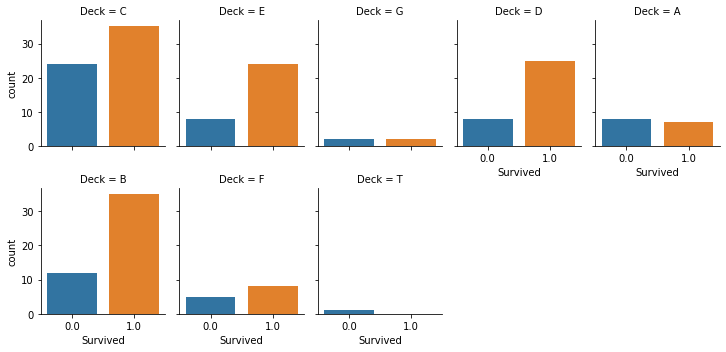

In [12]:
plt.figure(figsize=(15,10))
g = sns.catplot("Survived", col="Deck", col_wrap=5,
                data=df[df['Survived'].notnull()],
                kind="count", height=2.5, aspect=.8)

In [13]:
#Create a category for the missing data of cabin

df['Deck'] = df['Deck'].fillna('N')
df[df['Deck'] != 'N'].sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
716,717,1.0,1,"Endres, Miss. Caroline Louise",female,38.00,0,0,PC 17757,227.5250,C45,C,C
305,306,1.0,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,C
1130,1131,NaN,1,"Douglas, Mrs. Walter Donald (Mahala Dutton)",female,48.00,1,0,PC 17761,106.4250,C86,C,C
776,777,0.0,3,"Tobin, Mr. Roger",male,NaN,0,0,383121,7.7500,F38,Q,F
318,319,1.0,1,"Wick, Miss. Mary Natalie",female,31.00,0,2,36928,164.8667,C7,S,C


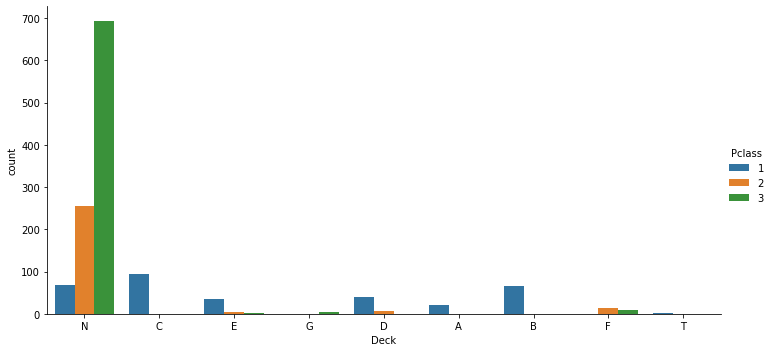

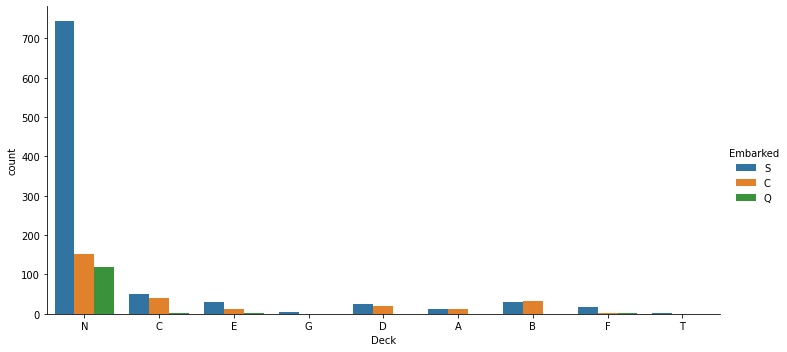

In [14]:
sns.catplot(x='Deck',hue='Pclass',data=df,kind='count',aspect=2)
sns.catplot(x='Deck',hue='Embarked',data=df,kind='count',aspect=2) #Seems to have no corelation

,Deck,Survived
3,D,0.757576
4,E,0.750000
1,B,0.744681
5,F,0.615385
2,C,0.593220
6,G,0.500000
0,A,0.466667
7,N,0.299854
8,T,0.000000


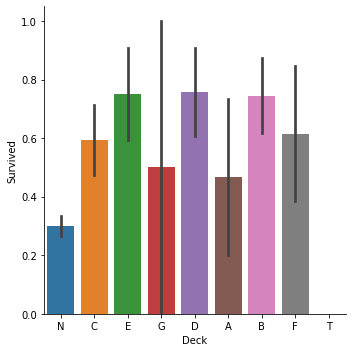

In [15]:
sns.catplot(x='Deck',y='Survived',data=df[df['Survived'].notnull()],kind='bar')
df_tmp = df[df['Survived'].notnull()]
df_tmp[['Deck','Survived']].groupby(by=['Deck'],as_index=False).mean().sort_values(by='Survived',ascending=False)

In [16]:
df.loc[df['Deck'] == 'T','Deck'] = 'A' #Fix this value - Map it 'A'
#Seems like people who have deck a survival rate atleast GT 0.5 - Assign a new feature HasDeck or No Deck 
df['DeckBin'] = [ 0 if deck_wa == 'N' else 1 for deck_wa in df['Deck'] ] 
#Group them further based on the mean rate of survival
df['DeckCode'] = np.nan
list1 = ['D','E','B']
df.loc[df['Deck'].isin(list1),'DeckCode'] = 1
list1 = ['F','C']
df.loc[df['Deck'].isin(list1),'DeckCode'] = 2
list1 = ['G']
df.loc[df['Deck'].isin(list1),'DeckCode'] = 3
list1 = ['A']
df.loc[df['Deck'].isin(list1),'DeckCode'] = 4
list1 = ['N']
df.loc[df['Deck'].isin(list1),'DeckCode'] = 5

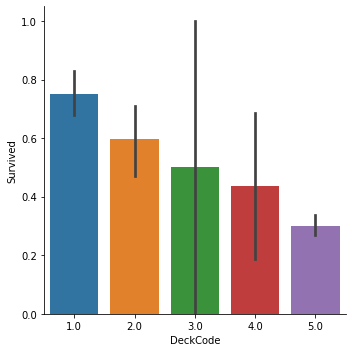

In [17]:
sns.catplot(x='DeckCode',y='Survived',data=df[df['Survived'].notnull()], aspect=1, kind='bar')

Handle the Missing Values for Age
- To do this, it will be helpful if we can evaluate title and group the data 



In [18]:
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(df['Sex'], df['Title'])
#Replace Ms with Miss
df.loc[df['Title']=='Ms','Title'] = 'Miss'

In [19]:
def find_titles(sex):
  rt = df[df['Sex'] == sex]['Title'].value_counts()
  raretitle = rt.index[ rt<10] 
  return raretitle


df.loc[(df['Title'].isin(find_titles('female'))) & (df['Sex']=='female'), 'Title'] = 'RareFemaleTitle'

df.loc[(df['Title'].isin(find_titles('male'))) & (df['Sex']=='male'), 'Title'] = 'RareMaleTitle'

df['Title'].value_counts()

Mr                 757
Miss               262
Mrs                197
Master              61
RareMaleTitle       25
RareFemaleTitle      7
Name: Title, dtype: int64

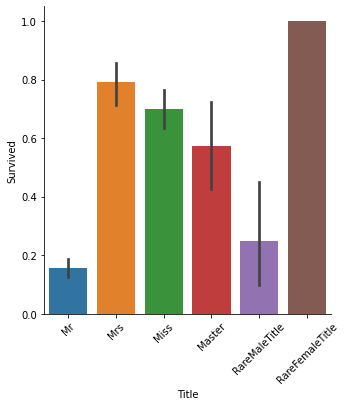

In [20]:
g = sns.catplot(x='Title',y='Survived',data=df[df['Survived'].notnull()],kind='bar')
g.set_xticklabels(rotation=45)
df['TitleRank'] = df['Title'].map({'Mr':1,'RareMaleTitle':2,'Master':3,'Mrs':4,'Miss':5,'RareFemaleTitle':6})

Examine Age and Impute the missing values

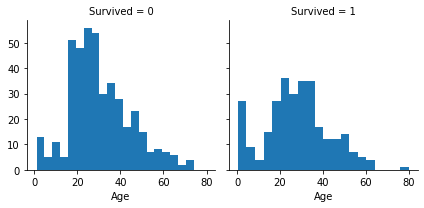

In [21]:
g=sns.FacetGrid(df_train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

In [22]:
df[df['Survived'].notnull()][['Title', 'Age']].groupby(['Title']).describe()

Age                                                       
                 count       mean        std    min    25%   50%    75%   max
Title                                                                        
Master            36.0   4.574167   3.619872   0.42   1.00   3.5   8.00  12.0
Miss             147.0  21.816327  12.955909   0.75  14.25  21.0  30.00  63.0
Mr               398.0  32.368090  12.708793  11.00  23.00  30.0  39.00  80.0
Mrs              108.0  35.898148  11.433628  14.00  27.75  35.0  44.00  63.0
RareFemaleTitle    6.0  33.666667  12.011106  24.00  24.00  28.5  44.25  49.0
RareMaleTitle     19.0  45.894737  12.332859  23.00  39.00  49.0  54.00  70.0

In [23]:
df[(df['Title'] == 'Miss') & (df['Age'] == 0.75)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,DeckBin,DeckCode,Title,TitleRank
469,470,1.0,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C,N,0,5.0,Miss,5
644,645,1.0,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C,N,0,5.0,Miss,5


In [24]:
df_ag1 = df[df['Age'] < 5]
df_ag1 = df_ag1[df_ag1['Survived'].notnull()]
pd.crosstab(df_ag1['Survived'],df_ag1['Pclass'])

Pclass,1,2,3
Survived,,,
0.0,1,0,12
1.0,2,12,13


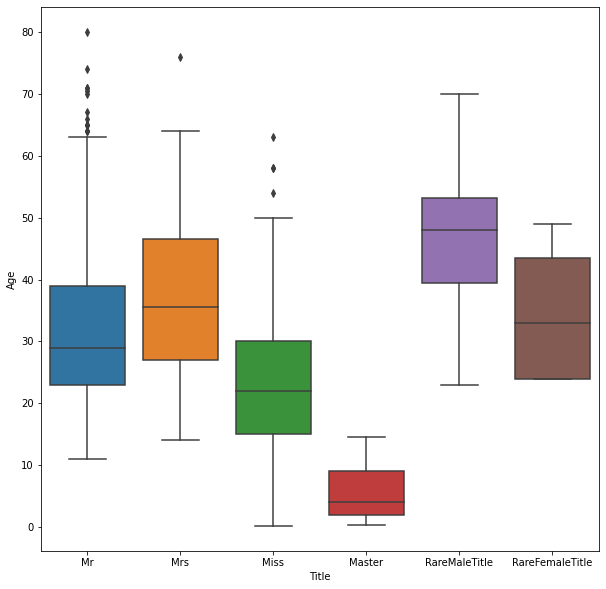

In [25]:
#Analyze the Categorical Variables


data = pd.concat([df['Age'], df['Title']], axis=1)
f, ax = plt.subplots(figsize=(10, 10))
fig = sns.boxplot(x='Title', y="Age", data=data)


In [26]:
df[df['Survived'].notnull()][['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.699454
2,Mr,0.156673
3,Mrs,0.792000
4,RareFemaleTitle,1.000000
5,RareMaleTitle,0.250000


Fill the missing values for Embarked 

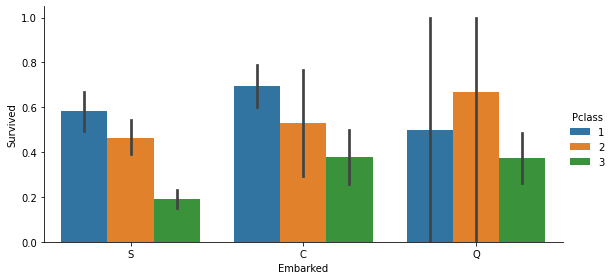

In [27]:
sns.catplot(x='Embarked',y='Survived', hue='Pclass', data=df[df['Survived'].notnull()],height=4,aspect=2,kind='bar')

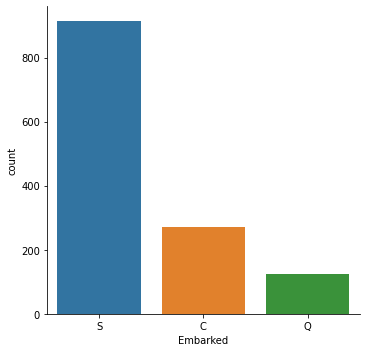

In [28]:
sns.catplot(x='Embarked',data=df,kind='count')


In [29]:
df[df['Embarked'].isnull()][['Fare','Pclass','Survived']]

,Fare,Pclass,Survived
61,80.0,1,1.0
829,80.0,1,1.0


In [30]:
df.groupby(by=['Embarked','Pclass'])['Fare'].agg(['mean','median','count','max'])

mean   median  count       max
Embarked Pclass                                      
C        1       106.845330  76.7292    141  512.3292
         2        23.300593  15.3146     28   41.5792
         3        11.021624   7.8958    101   22.3583
Q        1        90.000000  90.0000      3   90.0000
         2        11.735114  12.3500      7   12.3500
         3        10.390820   7.7500    113   29.1250
S        1        72.148094  52.0000    177  263.0000
         2        21.206921  15.3750    242   73.5000
         3        14.435422   8.0500    494   69.5500

In [31]:
#Going with mode, S1 -80$ close to mean 
df['Embarked'] = df['Embarked'].fillna('S')

In [32]:
#Fill the missed value Fare and Correct the outliers
grouped = df.groupby(['Embarked','Pclass'])
df['Fare'] = grouped.Fare.apply(lambda x: x.fillna(x.median()))
df['FareBin'] = pd.cut(df['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare',
                                                                                      'Average_fare','high_fare'])

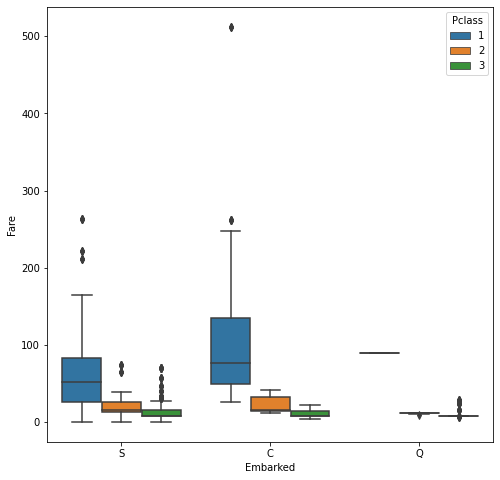

In [33]:
data = pd.concat([df['Fare'], df['Embarked'],df['Pclass']], axis=1)
f, ax = plt.subplots(figsize=(8, 8))
fig = sns.boxplot(x='Embarked', y="Fare", data=data,hue='Pclass')

In [34]:
#Convert Embarked to Ordinal
df['Embarked'] = df['Embarked'].map({'Q':1,'C':2,'S':3})

In [35]:

#Clear up the outliers and fill with median to ensure we do not give wrong weightage
df['Fare'] = pd.to_numeric(df['Fare'],errors='coerce')
x = df.groupby(by=['Embarked','Pclass'])['Fare'].median()
x1 = x.reset_index()
val = x1[(x1['Embarked'] == 2) & (x1['Pclass'] == 1)]['Fare'].values[0]
df.loc[(df['Fare'] > 150) & (df['Pclass'] == 1 ) & (df['Embarked'] == 2), 'Fare'] = val

In [36]:
val = x1[(x1['Embarked'] == 3) & (x1['Pclass'] == 1)]['Fare'].values[0]
df.loc[(df['Fare'] > 150) & (df['Pclass'] == 1 ) & (df['Embarked'] == 3), 'Fare'] = val

In [37]:
df.groupby(['Embarked','Pclass'])['Fare'].describe(percentiles=[0.1,0.25, 0.5,  0.75 ,0.9])


count       mean        std  ...       75%        90%       max
Embarked Pclass                               ...                               
1        1         3.0  90.000000   0.000000  ...  90.00000   90.00000   90.0000
         2         7.0  11.735114   1.090680  ...  12.35000   12.35000   12.3500
         3       113.0  10.390820   6.040804  ...   7.87920   21.70000   29.1250
2        1       141.0  71.511087  32.141879  ...  83.15830  113.27500  146.5208
         2        28.0  23.300593  11.082198  ...  31.80415   41.57920   41.5792
         3       101.0  11.021624   4.862605  ...  14.45830   18.78750   22.3583
3        1       179.0  50.249115  26.396768  ...  57.00000   82.50836  135.6333
         2       242.0  21.206921  13.969256  ...  26.00000   33.00000   73.5000
         3       495.0  14.422522  13.108139  ...  15.90000   31.27500   69.5500

[9 rows x 10 columns]

In [38]:
#There are no outliers for Master, RareMaleTitle, RareFemaleTitle. We can fill these Ages with random values
#First populate using combined group by and check if it introduces any outliers
grouped = df.groupby(['Sex','Pclass', 'Title'])
df['Age'] = grouped.Age.apply(lambda x: x.fillna(x.median()))

In [39]:
df.isnull().sum()[df.isnull().sum().values > 0] 

Survived     418
Cabin       1014
FareBin       84
dtype: int64

# New Features
We have already added the features 
1. Deck - Based on Cabin 
2. Title - Based on Name<b></b> 

Now - Ticket Frequency

In [40]:
print(df['Ticket'].nunique())
print(len(df))


929
1309


In [41]:

duplicateTicketRows = df[df.duplicated('Ticket')]
duplicateTicketRows.sort_values(by='Ticket',inplace=True)

duplicateTicketRows[['Name','Ticket','SibSp','Parch','Pclass','Embarked','Survived']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Name,Ticket,SibSp,Parch,Pclass,Embarked,Survived
759,"Rothes, the Countess. of (Lucy Noel Martha Dye...",110152,0,0,1,3,1.0
504,"Maioni, Miss. Roberta",110152,0,0,1,3,1.0
558,"Taussig, Mrs. Emil (Tillie Mandelbaum)",110413,1,1,1,3,1.0
585,"Taussig, Miss. Ruth",110413,0,2,1,3,1.0
475,"Clifford, Mr. George Quincy",110465,0,0,1,3,0.0
...,...,...,...,...,...,...,...
436,"Ford, Miss. Doolina Margaret ""Daisy""",W./C. 6608,2,2,3,3,0.0
1058,"Ford, Mr. Edward Watson",W./C. 6608,2,2,3,3,NaN
736,"Ford, Mrs. Edward (Margaret Ann Watson)",W./C. 6608,1,3,3,3,0.0
905,"Chaffee, Mrs. Herbert Fuller (Carrie Constance...",W.E.P. 5734,1,0,1,3,NaN


In [42]:
df['Ticket_Frequency'] = df.groupby('Ticket')['Ticket'].transform('count')

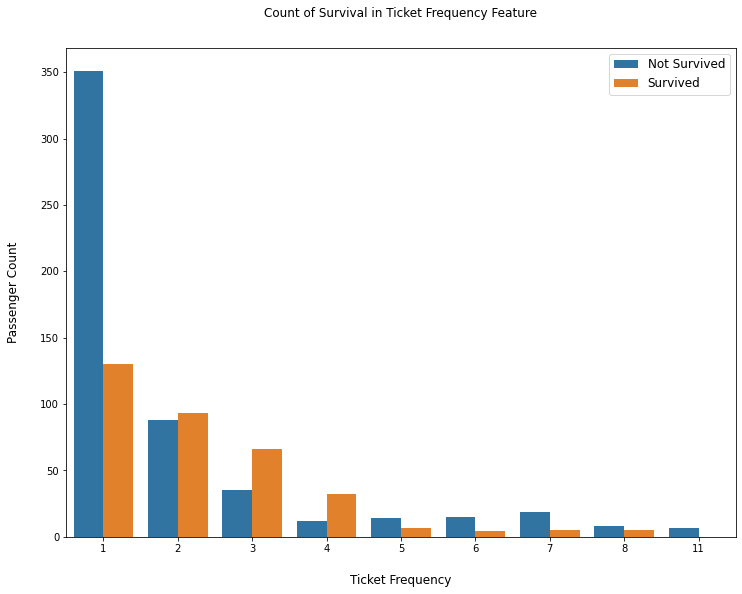

In [43]:
fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df)

plt.xlabel('Ticket Frequency', size=12, labelpad=20)
plt.ylabel('Passenger Count', size=12, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 12})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=12, y=1.05)

plt.show()

Handle Family Size

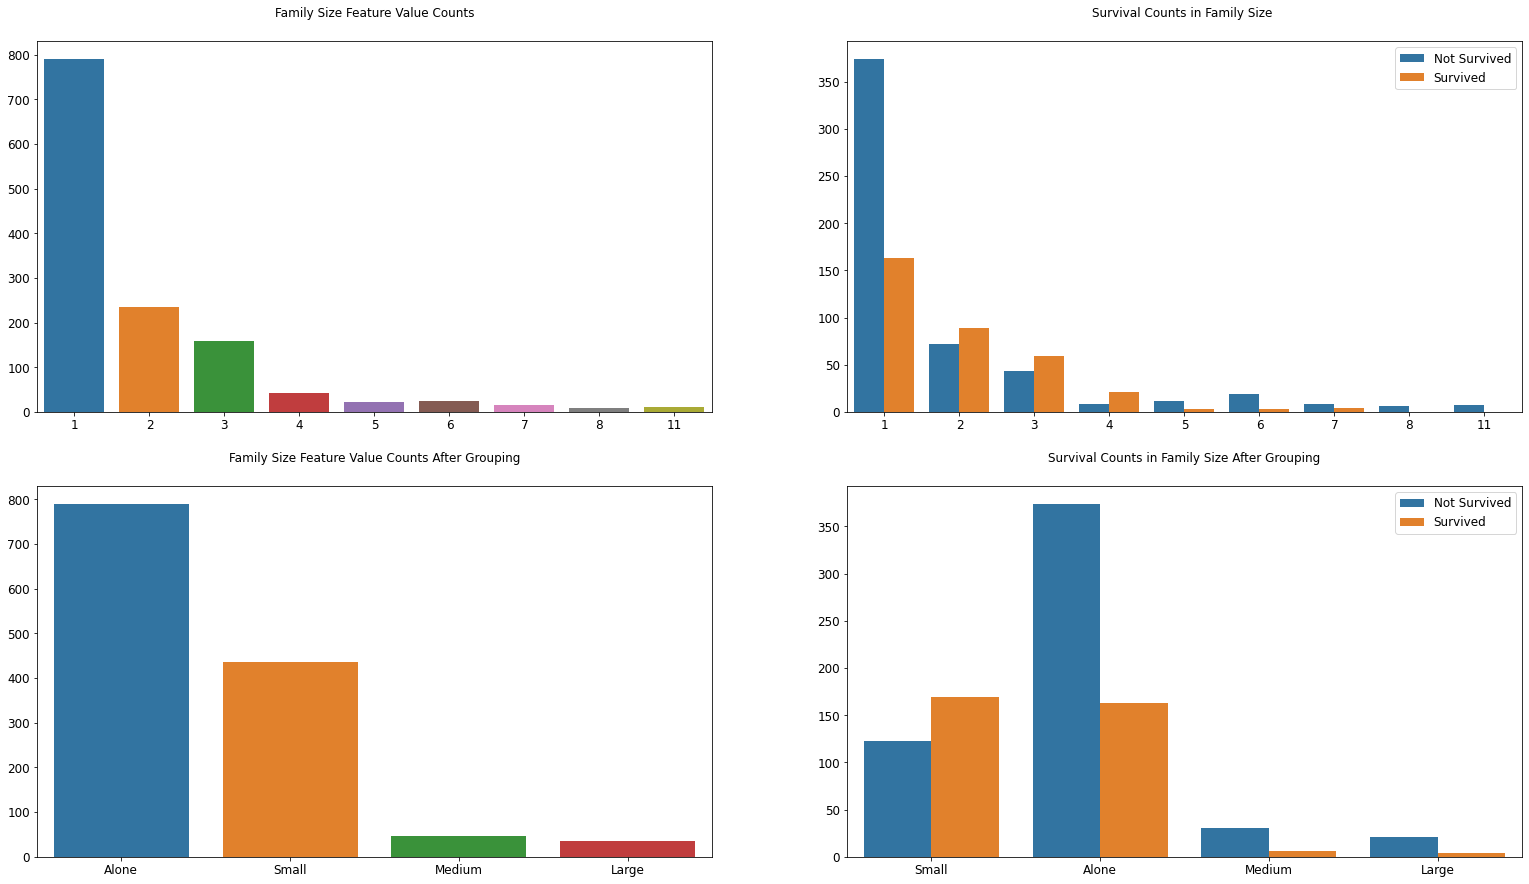

In [44]:

df['Family_Size'] = df['SibSp'] + df['Parch'] + 1
df['HasFamily'] = [ 1 if x > 1 else 0 for x in df['Family_Size'] ]
fig, axs = plt.subplots(figsize=(15, 15), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df['Family_Size'].value_counts().index, y=df['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=12, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=12, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df['Family_Size_Grouped'] = df['Family_Size'].map(family_map)

sns.barplot(x=df['Family_Size_Grouped'].value_counts().index, y=df['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=12, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=12, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 12})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=12)
        axs[i][j].tick_params(axis='y', labelsize=12)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

In [45]:
"Convert Age and Fare Into Bins"
#df['AgeBin'] = pd.cut(df['Age'], 5)
df['AgeBin'] = pd.cut(df['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])
#df['FareBin'] = pd.qcut(df['Fare'], 13)
#label = LabelEncoder()
#df['AgeBin_Code'] = label.fit_transform(df['AgeBin'])
#df['FareBin_Code'] = label.fit_transform(df['FareBin'])

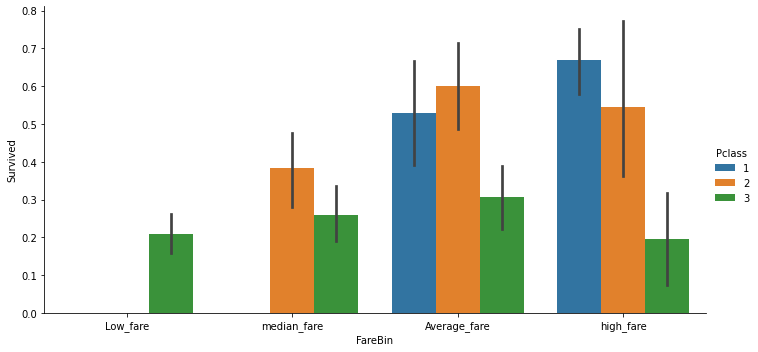

In [46]:
sns.catplot(x='FareBin',y='Survived',hue='Pclass',data=df[df['Survived'].notnull()],kind='bar',aspect=2)

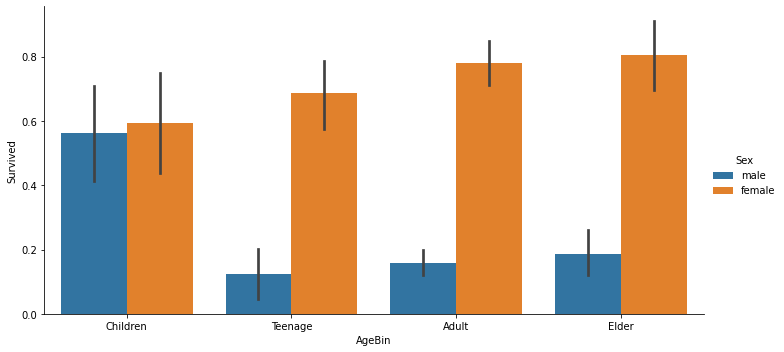

In [47]:
sns.catplot(x='AgeBin',y='Survived',data=df[df['Survived'].notnull()],hue='Sex',kind='bar',estimator=np.mean,aspect=2)

Check and Model the Data

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          1309 non-null   int64   
 1   Survived             891 non-null    float64 
 2   Pclass               1309 non-null   int64   
 3   Name                 1309 non-null   object  
 4   Sex                  1309 non-null   object  
 5   Age                  1309 non-null   float64 
 6   SibSp                1309 non-null   int64   
 7   Parch                1309 non-null   int64   
 8   Ticket               1309 non-null   object  
 9   Fare                 1309 non-null   float64 
 10  Cabin                295 non-null    object  
 11  Embarked             1309 non-null   int64   
 12  Deck                 1309 non-null   object  
 13  DeckBin              1309 non-null   int64   
 14  DeckCode             1309 non-null   float64 
 15  Title                

In [49]:
#Add the fields irrelevant till now to a drop list
droplist = ["PassengerId",'Name','Ticket',"DeckCode",'Cabin','DeckBin','Ticket_Frequency',\
            'Age','Fare','Deck','Title','Family_Size_Grouped']
df_final = df.drop(droplist,axis=1)
df_final = pd.get_dummies(df_final,columns=["Sex","AgeBin","FareBin"],drop_first=True)

In [50]:
df_final.isnull().sum()

Survived                418
Pclass                    0
SibSp                     0
Parch                     0
Embarked                  0
TitleRank                 0
Family_Size               0
HasFamily                 0
Sex_male                  0
AgeBin_Teenage            0
AgeBin_Adult              0
AgeBin_Elder              0
FareBin_median_fare       0
FareBin_Average_fare      0
FareBin_high_fare         0
dtype: int64

In [51]:
# create train and test data
X_train = df_final[ :train_idx]
y_train = X_train.Survived.astype(int).values
X_train = X_train.drop('Survived', axis=1).values 

X_test = df_final[test_idx: ]
X_test = X_test.drop('Survived', axis=1).values


# Feature Scaling
## We will be using standardscaler to transform
from sklearn.preprocessing import StandardScaler
st_scale = StandardScaler()

## transforming "train_x"
#X_train = st_scale.fit_transform(X_train)
## transforming "test_x"
#X_test = st_scale.transform(X_test)



In [52]:
df_final.sample(5)

,Survived,Pclass,SibSp,Parch,Embarked,TitleRank,Family_Size,HasFamily,Sex_male,AgeBin_Teenage,AgeBin_Adult,AgeBin_Elder,FareBin_median_fare,FareBin_Average_fare,FareBin_high_fare
125,1.0,3,1,0,2,3,2,1,1,0,0,0,1,0,0
249,0.0,2,1,0,3,2,2,1,1,0,0,1,0,1,0
69,0.0,3,2,0,3,1,3,1,1,0,1,0,1,0,0
637,0.0,2,1,1,3,1,3,1,1,0,1,0,0,1,0
720,1.0,2,0,1,3,5,2,1,0,0,0,0,0,0,1


#Metrics Evaluation


In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve

In [54]:
#Logistic Regression
lr_model = LogisticRegression(max_iter=50000)

cross_val_score(lr_model,X_train,y_train,cv=3,scoring="accuracy")

array([0.79124579, 0.82154882, 0.81818182])

In [55]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
cross_val_score(nb_model,X_train,y_train,cv=3,scoring="accuracy")

array([0.74747475, 0.81481481, 0.78787879])

In [56]:
#Evaluate a Model based on Test Train Split - Single Fold

X_strain, X_stest, y_strain, y_stest = train_test_split(X_train, y_train, test_size = 0.3)
lr_model.fit(X_strain,y_strain)
y_pred_slr = lr_model.predict(X_stest)
print(classification_report(y_stest, y_pred_slr))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       161
           1       0.75      0.75      0.75       107

    accuracy                           0.80       268
   macro avg       0.79      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268



In [57]:
confusion_matrix(y_stest, y_pred_slr)

array([[134,  27],
       [ 27,  80]])

In [58]:
print("Logistic Regression Evaluation:", accuracy_score(y_stest, y_pred_slr))

Logistic Regression Evaluation: 0.7985074626865671


In [59]:
#Repeat the Same for NaiveBayes

X_strain, X_stest, y_strain, y_stest = train_test_split(X_train, y_train, test_size = 0.3)
nb_model.fit(X_strain,y_strain)
y_pred_snb = lr_model.predict(X_stest)
print(classification_report(y_stest, y_pred_snb))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       164
           1       0.82      0.73      0.77       104

    accuracy                           0.83       268
   macro avg       0.83      0.81      0.82       268
weighted avg       0.83      0.83      0.83       268



In [60]:
confusion_matrix(y_stest, y_pred_snb)

array([[147,  17],
       [ 28,  76]])

In [61]:
print("NaiveBayes Evaluation:", accuracy_score(y_stest, y_pred_snb))

NaiveBayes Evaluation: 0.832089552238806


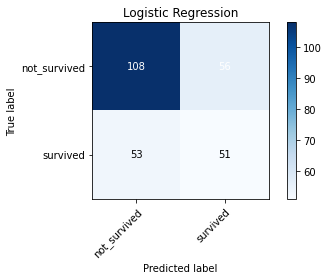

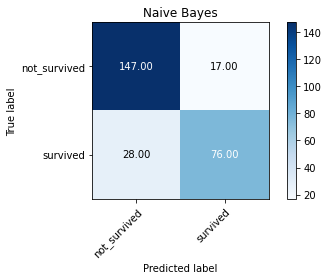

In [62]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

class_names = np.array(['not_survived','survived'])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_stest, y_pred_slr, classes=class_names,
                      title='Logistic Regression')

# Plot normalized confusion matrix
plot_confusion_matrix(y_stest, y_pred_snb, classes=class_names, normalize=True,
                      title='Naive Bayes')

plt.show()

ROC Curve Area for Logistic Regression 0.88 
ROC Curve Area for Naive Bayes 0.87 
P/R Curve Area for Logistic Regression 0.85 
P/R Curve Area for Naive Bayes Regression 0.83 


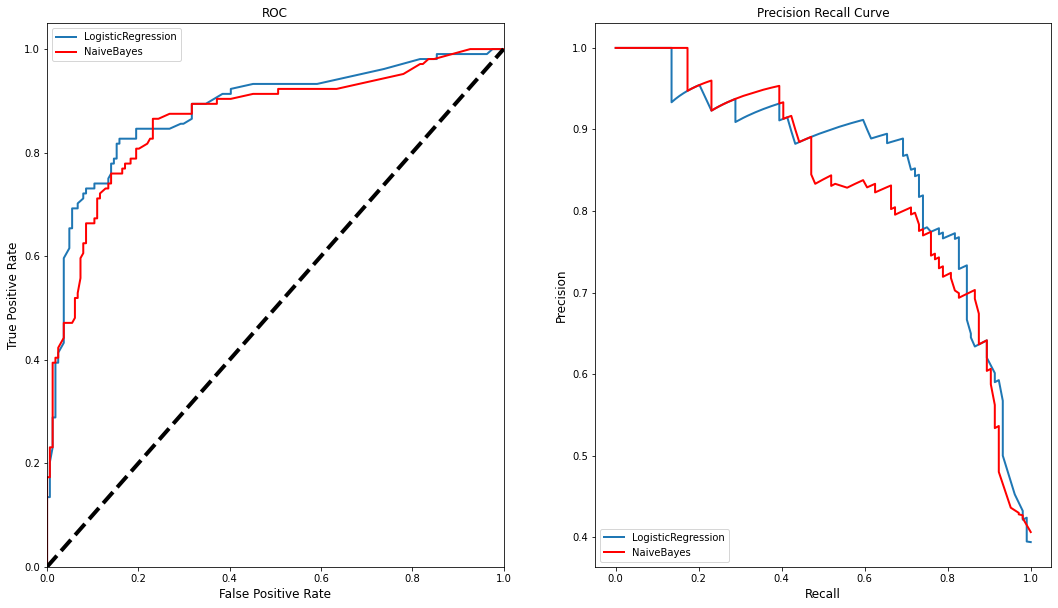

In [63]:
from sklearn.metrics import roc_curve, auc
#plt.style.use('seaborn-pastel')
y_score_lr = lr_model.decision_function(X_stest)
y_score_nb = nb_model.predict_proba(X_stest)[:,1]
FPR, TPR, _ = roc_curve(y_stest, y_score_lr)
FPR1, TPR1, _ = roc_curve(y_stest, y_score_nb)
ROC_AUC_lr = auc(FPR, TPR)
ROC_AUC_nb = auc(FPR1, TPR1)
print("ROC Curve Area for Logistic Regression %0.2f " % ROC_AUC_lr)
print("ROC Curve Area for Naive Bayes %0.2f " % ROC_AUC_nb)
plt.figure(figsize =[18,10])
plt.subplot(1,2,1)
plt.plot(FPR, TPR, linewidth= 2)
plt.plot(FPR1,TPR1,c='red',linewidth=2)
plt.plot([0,1],[0,1], 'k--', linewidth = 4)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate', fontsize = 12)
plt.ylabel('True Positive Rate', fontsize = 12)
plt.title('ROC', fontsize= 12)
plt.legend(['LogisticRegression','NaiveBayes'])




precision_lr, recall_lr, _ = precision_recall_curve(y_stest, y_score_lr)
PR_AUC_lr = auc(recall_lr, precision_lr)
print("P/R Curve Area for Logistic Regression %0.2f " % PR_AUC_lr)
precision_nb, recall_nb, _ = precision_recall_curve(y_stest, y_score_nb)
PR_AUC_nb = auc(recall_nb, precision_nb)
print("P/R Curve Area for Naive Bayes Regression %0.2f " % PR_AUC_nb)
plt.subplot(1,2,2)
plt.plot(recall_lr, precision_lr, linewidth=2)
plt.plot(recall_nb, precision_nb, c='red', linewidth=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision Recall Curve', fontsize=12)
plt.legend(['LogisticRegression','NaiveBayes'],loc="lower left")
plt.show()

#Fit the Model


In [64]:
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
pred_df = pd.DataFrame(y_pred_lr, index=df_test["PassengerId"], columns=["Survived"])
pred_df['Survived'] = pred_df['Survived'].astype(int)
pred_df.to_csv('Assignment_3_lr.csv', header=True, index_label='PassengerId')
print(df_test.shape, len(pred_df))

(418, 11) 418


In [65]:
pred_df.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0


In [66]:
nb_model.fit(X_train,y_train)
y_pred_nb = nb_model.predict(X_test)
pred_df = pd.DataFrame(y_pred_nb, index=df_test["PassengerId"], columns=["Survived"])
pred_df['Survived'] = pred_df['Survived'].astype(int)
pred_df.to_csv('Assignment_3_nb.csv', header=True, index_label='PassengerId')
print(df_test.shape, len(pred_df))

(418, 11) 418


In [67]:
pred_df.head(5)

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
